In [1]:
#import required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.svm import SVC #Support Vector Classifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [2]:
#wine = pd.read_csv('C:/Users/thenry/OneDrive/Northwestern Data Science Boot Camp/Wine Project/wineQualityReds.csv', sep=',')
wine = pd.read_csv('C:/Users/thenry/OneDrive/Northwestern Data Science Boot Camp/Wine Project/winemag-data-130k-v2.csv', sep=',')

In [3]:
wine.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [5]:
wine.isnull().sum()

id                           0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

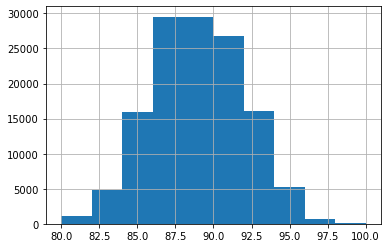

In [6]:
wine.points.hist()

In [7]:
wine.describe()

,id,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [8]:
#preprocessing
#bins = (2, 91, 100)
# group_names = ['bad', 'good']
# wine['points'] = pd.cut(wine['points'],bins=bins, labels=group_names)
# wine['points'].unique()

In [9]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words='english')
X = vectorizer.fit_transform(wine["description"]).toarray()

In [10]:
y = wine['points']

In [11]:
#train and test splitting data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [12]:
#apply standard scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
X_train[:10]

array([[-0.04690593, -0.11604373, -0.12637   , ..., -0.07622749,
        -0.08989389, -0.05642619],
       [-0.04690593, -0.11604373, -0.12637   , ..., -0.07622749,
        -0.08989389, -0.05642619],
       [-0.04690593, -0.11604373, -0.12637   , ..., -0.07622749,
        -0.08989389, -0.05642619],
       ...,
       [-0.04690593, -0.11604373, -0.12637   , ..., -0.07622749,
        -0.08989389, -0.05642619],
       [-0.04690593, -0.11604373, -0.12637   , ..., -0.07622749,
        -0.08989389, -0.05642619],
       [-0.04690593, -0.11604373, -0.12637   , ..., -0.07622749,
        -0.08989389, -0.05642619]])

In [14]:
#3 models
# 1. Random Forest Classifier
# 2. Support Vector Classifier
# 3. Neural Network (MLPClassifier)



In [15]:
rfc = RandomForestRegressor(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

KeyboardInterrupt: 

In [ ]:
pred_rfc[:20]

In [ ]:
X_test[:20]

In [ ]:
print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

SVM Classifier (for smaller numbers)

In [ ]:
clf=svm.SVC()
clf.fit(X_train, y_train)
pred_clf = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_clf))
print(confusion_matrix(y_test, pred_clf))

Neural Network

In [ ]:
mlpc=MLPClassifier(hidden_layer_sizes=(11,11,11),max_iter=500)
mlpc.fit(X_train, y_train)
pred_mlpc=mlpc.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_mlpc))
print(confusion_matrix(y_test, pred_mlpc))

In [ ]:
from sklearn.metrics import accuracy_score
cm=accuracy_score(y_test, pred_rfc)
cm

In [ ]:
Linear Model

In [ ]:
Nearest Neighbors